<a href="https://colab.research.google.com/github/YogeshMaan/MAE598-Design-Optimization/blob/main/Project_2_MPC_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install cvxpy==1.4.1
!pip install cvxpylayers==0.1.6
!pip install ipywidgets
!pip install jupyterthemes



```
# This is formatted as code
```

# Project 2: Model predictive control


## 1. Introduction
Consider a simple formulation of Bicopter hovering at a point in space where the dynamic state vector $\textbf{x}(t)$ is represented by its coordinates $y(t)$, $z(t)$, and $\theta(t)$ velocity $\dot{y}(t)$, $\dot{z}(t)$, and  $\dot{\theta}(t)$, i.e., $\textbf{x}(t) = [y(t), z(t), \theta(t), \dot{y}(t), \dot{z}(t), \dot{\theta}(t)]^T$, where $t$ specifies time. The control input $\textbf{u}(t)$ to Bicopter includes thrust $u_1(t)$ and $u_2(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
& y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 (\frac{u_1(t) + u_2(t)}{m})\sin(\theta(t)) \Delta t^2, \\
& z(t+1) = z(t) + \dot{z}(t) \Delta t + 0.5 (\frac{u_1(t) + u_2(t)}{m})\cos(\theta(t)) \Delta t^2, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t + 0.5 (\frac{(u_1(t) - u_2(t))*L}{I_{xx}})\Delta t^2, \\                                 \\
& \dot{y}(t+1) = \dot{y}(t) + (\frac{u_1(t) + u_2(t)}{m})\sin(\theta(t)) \Delta t \\
& \dot{z}(t+1) = \dot{z}(t) + (\frac{u_1(t) + u_2(t)}{m})\cos(\theta(t)) \Delta t \\
& \dot{\theta}(t+1) = \dot{\theta}(t) + (\frac{(u_1(t) - u_2(t))*L}{I_{xx}}) \Delta t,
& \end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
\textbf{u}(t) = [u_1(t), u_2(t)] = \pi_{w}(\textbf{x}(t))
$$

where $\pi_{w}(\cdot)$ is a neural network with parameters $w$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(\textbf{x}(t),\textbf{u}(t))$. In this example, we will simply set $l(\textbf{x}(t),\textbf{u}(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(\textbf{x}(T),\textbf{u}(T)) = ||\textbf{x}(T)||^2$.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 \\
\quad & \quad y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 (\frac{u_1(t) + u_2(t)}{m})\sin(\theta(t)) \Delta t^2, \\
\quad & \quad z(t+1) = z(t) + \dot{z}(t) \Delta t + 0.5 (\frac{u_1(t) + u_2(t)}{m}\cos\theta(t)- g) \Delta t^2, \\
\quad & \quad \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t + 0.5 (\frac{(u_1(t) - u_2(t))*L}{I_{xx}})\Delta t^2, \\                                 \\
\quad & \quad \dot{y}(t+1) = \dot{y}(t) + (\frac{u_1(t) + u_2(t)}{m})\sin(\theta(t)) \Delta t \\
\quad & \quad \dot{z}(t+1) = \dot{z}(t) + (\frac{u_1(t) + u_2(t)}{m}\cos\theta(t) - g) \Delta t \\
\quad & \quad \dot{\theta}(t+1) = \dot{\theta}(t) + (\frac{(u_1(t) - u_2(t))*L}{I_{xx}}) \Delta t, \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $\textbf{x}(T-1)$ and $\textbf{u}(T-1)$, where $\textbf{x}(T-1)$ as a function of $\textbf{x}(T-2)$ and $\textbf{u}(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $w$.

In the following, we code the forward pass of the loss using [PyTorch](https://pytorch.org/), which then automatically computes the gradient $\nabla_{w} l(\textbf{x}(T),\textbf{u}(T))$.

---

## 2. Sample Code

Before start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*.

The key step in MPC is to use linearized dynamics. To do so, we use Taylor's expansion of the dynamics $f(\textbf{x},u(t))$ at the current state $\textbf{x}_0$ and zero control input:
$$
A = \nabla_x f = \left[\begin{array}{lllll}1 & 0 & 0 & \Delta t & 0 & 0 \\
                                           0 & 1 & 0 & 0 & \Delta t & 0 \\
                                           0 & 0 & 1 & 0 & 0 & \Delta t\\
                                           0 & 0 & 0 & 1 & 0 & 0 \\
                                           0 & 0 & 0 & 0 & 1 & 0 \\
                                           0 & 0 & 0 & 0 & 0 & 1\end{array}\right]
$$
and
$$
B = \nabla_u f = \left[\begin{array}{lllll}0 & 0 \\
                                           0 & 0 \\
                                           \sin(\theta)\Delta t & sin(\theta)\Delta \\
                                           \cos(\theta)\Delta t & \cos(\theta)\Delta t \\
                                            \Delta t & -\Delta t \end{array}\right]
$$

Then we have
$$
f(\textbf{x},u) \approx f(\textbf{x}_0,0) + A(\textbf{x}-\textbf{x}_0) + Bu
$$

Since $f(\textbf{x}_0,0) = A\textbf{x}_0 + c$, where $c = [0,0,0,-g\Delta t,0]$, we have
$$
f(\textbf{x},u) \approx A\textbf{x} + Bu + c
$$
This will be the linear dynamics we use in formulating MPC.

In [148]:
# Code updated from former student: https://github.com/siddahant/DESOPT/blob/RocketLanding/Rocket_Landing_Optimization.ipynb

# overhead
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')

from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

In [149]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer
import numpy as np

In [150]:
n_state = 6
n_action = 2
T = 200
dt = .02
x_0 = np.array([5. , 10.0, -0.5, 0., 0., 0.])
total_time_step = 200

action_trajectory = []
state_trajectory = []

#environment parameters
FRAME_TIME = 0.1 # time_interval
GRAVITY_ACCEL_Y = .15  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.0  # gravity constant in X direction
BOOST_ACCEL = 0.18  # thrust constant
OMEGA_RATE = .1  # reducing it increases the Ixx

In [151]:
def mpc(x_0, T):

    x = cp.Variable((n_state, T + 1))
    u = cp.Variable((n_action, T))

    theta0 = x_0[2]
    A = np.array([[1, 0, 0, dt, 0, 0],
                [0, 1, 0, 0, dt, 0],
                [0, 0, 1, 0, 0, dt],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])
    B = np.array([[0, 0],
                [0, 0],
                [0, 0],
                [np.sin(theta0)*dt, np.sin(theta0)*dt],
                [np.cos(theta0)*dt, np.cos(theta0)*dt],
                [dt*OMEGA_RATE, -dt * OMEGA_RATE]])
    c = np.array([0,0,0,0,-GRAVITY_ACCEL_Y*dt,0])
    cost = 0
    constr = []
    for t in range(T):
        constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + c,
                   u[0, t] <= 2,
                   u[1, t] <= 2,
                   u[0, t] >= 0,
                   u[1, t] >= 0,


                   x[1, t] >= 0]
    cost = cp.sum_squares(x[:, T])
    #cost = 10000*cp.square(x[0, T]) + cp.sum_squares(x[:, T])

    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()
    return x, u

In [152]:
def visualize(x,u):
    data = x
    action_data = u
    y = data[:][0]
    z = data[:][ 1]
    theta = data[:][2]
    vy = data[:][3]
    vz = data[:][ 4]
    theta_dot = data[:][ 5]


    thrust1 = action_data[:,0]
    thrust2 = action_data[:,1]

    frame = range(T)

    fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

    ax[0].plot(y, z, c = 'b')
    ax[0].set_xlabel("Y")
    ax[0].set_ylabel("Z")
    ax[0].set(title=f'Displacement plot(y-z) at frame')

    ax[1].plot(frame, vy, c = 'c', label = "Velocity in y")
    ax[1].plot(frame, vz, c = 'r', label = "Velocity in z")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Velocity (m/s)")
    ax[1].legend(frameon=0)
    ax[1].set(title =f'Velocity plot at frame')

    ax[2].plot(frame, theta, c = 'g', label = "theta")
    ax[2].set_xlabel("Time interval")
    ax[2].set_ylabel("Theta")
    ax[2].legend(frameon=0)
    ax[2].set(title=f'Theta plot')

    ax[3].plot(frame, thrust1, c = 'y', label = "thrust1")
    ax[3].plot(frame, thrust2, c = 'b', label = "thrust2")
    ax[3].set_xlabel("Time interval")
    ax[3].set_ylabel("Thrust")
    ax[3].legend(frameon=0)
    ax[3].set(title=f'Thrust plot')
    plt.show()

In [153]:
def simulate(state, action):
    delta_state_gravity = np.array([0., 0., 0. , 0., -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])
    state_tensor = np.zeros(6)
    state_tensor[3] = np.sin(state[2])
    state_tensor[4] = np.cos(state[2])


    delta_state = FRAME_TIME * state_tensor * action[0] + FRAME_TIME * state_tensor * action[1]

    # Theta
    delta_state_theta = FRAME_TIME * OMEGA_RATE * np.array([0., 0., 0., 0., 0., 1.])*action[0] + FRAME_TIME * OMEGA_RATE * np.array([0., 0., 0., 0., 0., -1.])*action[1]

    # Update state
    step_mat = np.array([[1., 0., 0., FRAME_TIME, 0., 0.],
                              [0., 1., 0., 0., FRAME_TIME, 0.],
                              [0., 0., 1., 0., 0., FRAME_TIME],
                              [0., 0., 0., 1., 0., 0.],
                              [0., 0., 0., 0., 1., 0.],
                              [0., 0., 0., 0., 0., 1.]])

    shift_mat = np.array([[0., 0., 0., FRAME_TIME, 0., 0.],
                              [0., 0., 0., 0., FRAME_TIME, 0.],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.]])

    shift_mat_theta = np.array([[0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., FRAME_TIME,],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0.]])


    state = step_mat @ state + shift_mat @ delta_state * 0.5 + shift_mat @ delta_state_gravity * 0.5 + shift_mat_theta @ delta_state_theta
    state = state + delta_state  + delta_state_gravity + delta_state_theta

    return state

In [154]:
def control(x_0, total_time_step):
    x_current = x_0
    f = IntProgress(min = 0, max = total_time_step)
    display(f)
    for i in range(total_time_step):
        x, u = mpc(x_current, T-i)

        if u[:,0].value is None: # if the MPC problem is infeasible, stop
            print('MPC infeasible.')
            break

        # visualize(np.array(x[1:,:].value).T, np.array(u.value).T)
        action = u[:,0].value
        x_current = simulate(x_current, action)
        action_trajectory.append(action)
        state_trajectory.append(x_current)
        f.value += 1

control(x_0, total_time_step)

IntProgress(value=0, max=200)

Generating Animation


IntProgress(value=0, max=200)

(200, 6) (200, 2)


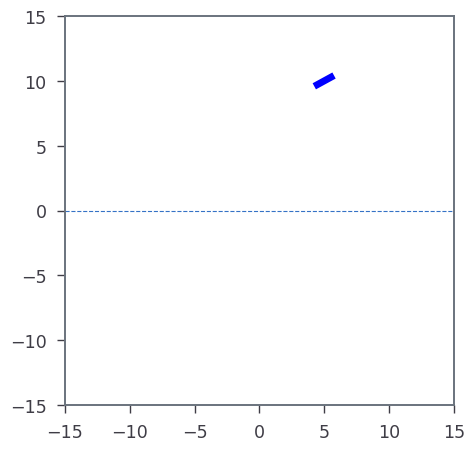

In [155]:
def animation(state_trajectory, action_trajectory):
        # Size
        length = 0.60          # m
        width = 0.04          # m

        v_exhaust = 1
        print("Generating Animation")
        steps = min(len(state_trajectory), len(action_trajectory))
        final_time_step = round(1/steps,3)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array(state_trajectory)
        action_data = np.array(action_trajectory)

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 5, color = 'blue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust1 line
        ln3, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust2 line

        plt.tight_layout()

        ax1.set_xlim(-15, 15)
        ax1.set_ylim(-15, 15)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            bc_theta = x_t[i, 2] # bc: bi-copter

            bc_y = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            bc_y_points = [bc_y - length/1 * np.cos(bc_theta), bc_y + length/1 * np.cos(bc_theta)]

            bc_z = x_t[i, 1]
            bc_z_points = [bc_z + length/1 * np.sin(bc_theta), bc_z - length/1 * np.sin(bc_theta)]

            ln1.set_data(bc_y_points, bc_z_points)

            thrust1_mag = u_t[i, 0]
            thrust2_mag = u_t[i, 1]

            flame1_length = (thrust1_mag) * (0.4/v_exhaust)
            flame2_length = (thrust2_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame1_y_points = [bc_y_points[0], bc_y_points[0] + flame1_length * np.sin(bc_theta)]
            flame1_z_points = [bc_z_points[0], bc_z_points[0] + flame1_length * np.cos(bc_theta)]

            flame2_y_points = [bc_y_points[1], bc_y_points[1] + flame2_length * np.sin(bc_theta)]
            flame2_z_points = [bc_z_points[1], bc_z_points[1] + flame2_length * np.cos(bc_theta)]

            ln2.set_data(flame1_y_points, flame1_z_points)
            ln3.set_data(flame2_y_points, flame2_z_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("bc_hovering.gif", writer=writer)

animation(state_trajectory, action_trajectory)



---




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e2a6456-b53d-4309-ad17-14f28135d7a4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>